In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model

# Load dataset
df = pd.read_csv("../data/cleaned_dataset.csv")

# Drop irrelevant columns with low correlation
columns_to_drop = [
    "Legislative District", 
    "Vehicle Location", 
    "Postal Code", 
    "City", 
    "2020 Census Tract", 
    "County", 
    "Electric Utility"
]

# Remove irrelevant columns
df = df.drop(columns=columns_to_drop)

# Filter out records where Electric Range is 0
df = df[df["Electric Range"] > 0]

# Define features and target
X = df.drop(columns=["Electric Range"]).fillna(df.mean(numeric_only=True))
y = df["Electric Range"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Residual block
def residual_block(x, units):
    shortcut = x
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(units)(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Model with residual connections
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = layers.Dense(128)(input_layer)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae:.2f}")

Epoch 1/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2139.1533 - mae: 20.9212 - val_loss: 104.8212 - val_mae: 5.4274
Epoch 2/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 94.2704 - mae: 5.4081 - val_loss: 66.1504 - val_mae: 4.2531
Epoch 3/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 64.2576 - mae: 4.3382 - val_loss: 76.6725 - val_mae: 4.9110
Epoch 4/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 56.9893 - mae: 3.9804 - val_loss: 87.6472 - val_mae: 4.9734
Epoch 5/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 55.2276 - mae: 3.8277 - val_loss: 48.8286 - val_mae: 3.1843
Epoch 6/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 51.8114 - mae: 3.6767 - val_loss: 78.0866 - val_mae: 4.7797
Epoch 7/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - loss: 48.1635 - mae: 3.6201 - val_loss: 43.8802 - val_mae: 2.6823
Epoch 8/200
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 41.9670 - mae: 3.3207 - val_loss: 49.0402 - val_mae: 3.3608
Epoch 9/20

In [6]:
# Predict electric range for the first 5 vehicles in test set
predictions = model.predict(X_test_scaled[:5])

# Show predictions alongside actual values
for i, (pred, actual) in enumerate(zip(predictions, y_test.iloc[:5])):
    print(f"Sample {i+1}: Predicted = {pred[0]:.2f}, Actual = {actual}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Sample 1: Predicted = 291.19, Actual = 291.0
Sample 2: Predicted = 207.63, Actual = 208.0
Sample 3: Predicted = 106.90, Actual = 107.0
Sample 4: Predicted = 258.48, Actual = 259.0
Sample 5: Predicted = 83.56, Actual = 84.0


595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step


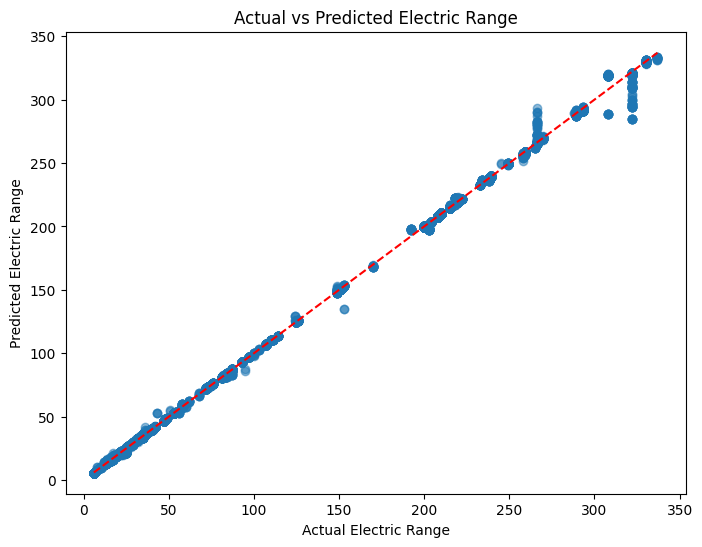

In [7]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Electric Range")
plt.ylabel("Predicted Electric Range")
plt.title("Actual vs Predicted Electric Range")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()
